In [154]:
import cv2
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt

In [155]:
image_pts = []
image_pts2 = []

def click_event(event, x, y, flags, params, image_pts):
    if event == cv2.EVENT_LBUTTONDOWN and len(image_pts) < 10:
        image_pts.append((x, y))
        print(f"Point {len(image_pts)}: ({x}, {y})")
        if len(image_pts) == 10:
            cv2.destroyAllWindows()

# Load your image
img = cv2.imread('../Assets/house1.png')
if img is None:
    raise FileNotFoundError("Could not load house1.png")
img2 = cv2.imread('../Assets/house2.png')
if img2 is None:
    raise FileNotFoundError("Could not load house2.png")
img0 = cv2.imread('../Assets/0.png')
if img0 is None:
    raise FileNotFoundError("Could not load 0.png")

with open('../Assets/coords.txt', 'r') as f:
    world_pts = []
    for line in f:
        coords = list(map(float, line.strip().split()))
        world_pts.append(coords)
    world_pts = np.array(world_pts, dtype=np.float32)


In [156]:
house = False

# Display image and collect 10 points
if house:
    cv2.namedWindow('Click 10 points', cv2.WINDOW_AUTOSIZE)
    while True:
        if house == 1:
            cv2.setMouseCallback('Click 10 points', click_event, image_pts)
            cv2.imshow('Click 10 points', img)

        elif house == 2:
            cv2.setMouseCallback('Click 10 points', click_event, image_pts2)
            cv2.imshow('Click 10 points', img2)
        # Small wait to process GUI events
        key = cv2.waitKey(1) & 0xFF
        if len(image_pts) >= 10 or key == ord('q'):
            # Close window and give GUI time to update
            cv2.destroyAllWindows()
            cv2.waitKey(1)
            break
    # save points to file
    with open(f'../Assets/house{house}_2D_points.txt', 'w') as f:
        for pt in image_pts:
            f.write(f"{pt[0]} {pt[1]}\n")

else:
    # Load points from file
    with open(f'../Assets/house1_2D_points.txt', 'r') as f:
        for line in f:
            x, y = map(float, line.strip().split())
            image_pts.append((x, y))
        image_pts = np.array(image_pts, dtype=float)

    with open(f'../Assets/house2_2D_points.txt', 'r') as f:
        for line in f:
            x, y = map(float, line.strip().split())
            image_pts2.append((x, y))
        image_pts2 = np.array(image_pts2, dtype=float)


In [159]:
# 3. Apply the DLT algorithm to compute the projection matrix P
def dlt_algorithm(world_pts, image_pts):
    n = world_pts.shape[0]
    A = np.zeros((2*n, 12))
    
    for i in range(n):
        X = world_pts[i]  # 3D world coordinates (homogeneous)
        x = image_pts[i]  # 2D image coordinates
        
        # First line for x coordinate
        A[2*i, 0:4] = X
        A[2*i, 8:12] = -x[0] * X
        
        # Second line for y coordinate
        A[2*i+1, 4:8] = X
        A[2*i+1, 8:12] = -x[1] * X
    
    # Solve Ap=0 using SVD
    U, S, Vt = linalg.svd(A)
    
    # p is the last column of V (last row of V transpose)
    p = Vt.T[:, -1]
    
    # Reshape into 3x4 projection matrix
    P = p.reshape(3, 4)
    
    return P

# 4. Decompose the projection matrix to get K, R, and C
def decompose_projection_matrix(P):
    # Extract the first 3x3 submatrix
    M = P[:, 0:3]
    
    # Use RQ decomposition to get K and R
    K, R = linalg.rq(M)
    
    # Make diagonal elements of K positive
    T = np.diag(np.sign(np.diag(K)))
    K = K @ T
    R = T @ R
    
    # Ensure determinant of R is positive (proper rotation matrix)
    if np.linalg.det(R) < 0:
        K = K @ np.diag([1, 1, -1])
        R = R @ np.diag([1, 1, -1])
    
    # Normalize K
    K = K / K[2, 2]
    
    # Compute camera center C
    # P = K[R|-RC]
    # So, P = [M|p4] and p4 = -M*C
    # Therefore, C = -inv(M)*p4
    p4 = P[:, 3]
    C = -np.linalg.inv(M) @ p4
    
    return K, R, C

# Optional: Calculate reprojection error to evaluate the solution
def calculate_reprojection_error(P, world_pts, image_pts):
    n = world_pts.shape[0]
    error = 0
    
    for i in range(n):
        X = world_pts[i]
        x = image_pts[i]
        
        # Project 3D point to image plane
        x_proj = P @ X
        x_proj = x_proj[:2] / x_proj[2]  # Normalize
        
        # Calculate Euclidean distance
        error += np.sqrt(np.sum((x - x_proj)**2))
    
    return error / n

Projection Matrix P:
[[-1.37859120e-01 -2.03596511e-01  1.31226289e-02 -7.42592695e-01]
 [ 6.45681792e-03 -1.02563597e-02  2.35089607e-01 -5.76637755e-01]
 [ 9.92912686e-05 -1.35832779e-04  2.85342277e-05 -1.43997725e-03]]

Calibration Matrix K:
[[-1.35620672e+03  5.60728034e-01  4.92431064e+02]
 [-0.00000000e+00 -1.34633405e+03  3.00182163e+02]
 [-0.00000000e+00 -0.00000000e+00  1.00000000e+00]]

Rotation Matrix R:
[[-0.80694332 -0.59061788  0.00360417]
 [-0.10162186  0.13282644 -0.98591589]
 [ 0.58182082 -0.7959445  -0.1672031 ]]

Camera Center C:
[ 4.72846021 -6.71827227  2.02987251]

Reconstructed Projection Matrix:
[[ 1.38083162e+03  4.09126620e+02 -8.77768327e+01 -3.60240756e+03]
 [ 3.11469205e+02 -4.17757105e+02  1.27718074e+03 -6.87188979e+03]
 [ 5.81820823e-01 -7.95944504e-01 -1.67203100e-01 -7.75908752e+00]]

Normalized Original P:
[[ 9.57370120e+01  1.41388699e+02 -9.11308068e+00  5.15697518e+02]
 [-4.48397216e+00  7.12258451e+00 -1.63259251e+02  4.00449211e+02]
 [-6.8953359

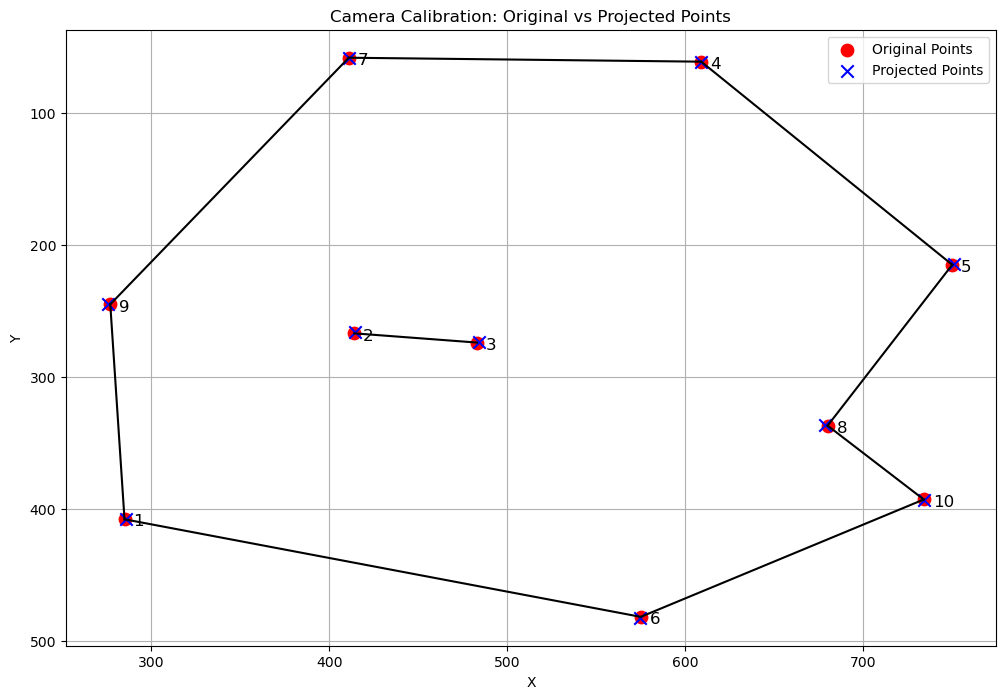

Projection Matrix P:
[[-2.22097015e-02 -2.65996224e-01  3.83319123e-03 -6.96882705e-01]
 [ 3.39135804e-02 -1.52852989e-02  2.51539163e-01 -6.15170710e-01]
 [ 1.68988963e-04 -7.70362116e-05  7.40269698e-06 -1.33442943e-03]]

Calibration Matrix K:
[[-1.35175053e+03 -4.34513286e-01  4.85329956e+02]
 [-0.00000000e+00 -1.34428222e+03  2.53877327e+02]
 [-0.00000000e+00 -0.00000000e+00  1.00000000e+00]]

Rotation Matrix R:
[[-4.14821009e-01 -9.09902812e-01 -6.35802314e-04]
 [-3.59759654e-02  1.70995009e-02 -9.99206354e-01]
 [ 9.09191542e-01 -4.14468914e-01 -3.98278642e-02]]

Camera Center C:
[ 6.4065642  -3.13477073  1.39137488]

Reconstructed Projection Matrix:
[[ 1.00200804e+03  1.02880000e+03 -1.80360411e+01 -3.16928184e+03]
 [ 2.79184969e+02 -1.28210815e+02  1.33310394e+03 -4.04537527e+03]
 [ 9.09191542e-01 -4.14468914e-01 -3.98278642e-02 -7.06864352e+00]]

Normalized Original P:
[[ 1.66435939e+01  1.99333302e+02 -2.87253199e+00  5.22232716e+02]
 [-2.54142929e+01  1.14545577e+01 -1.884994

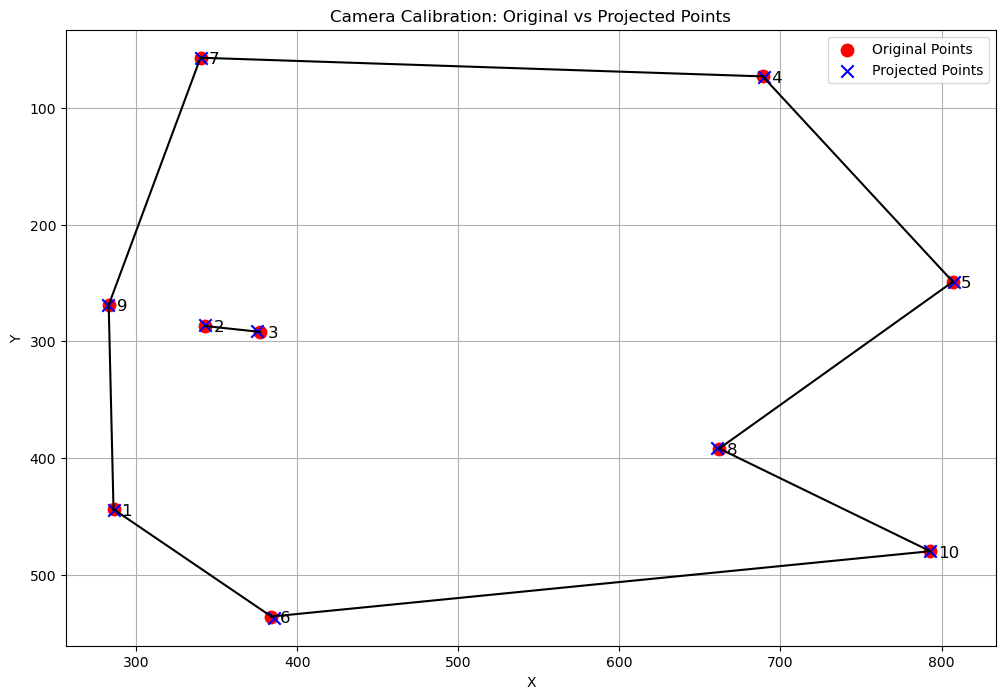

In [160]:
def part_1(image_pts, name):
    # Execute the DLT algorithm
    P = dlt_algorithm(world_pts, image_pts)
    print("Projection Matrix P:")
    print(P)

    # Decompose P to get K, R, and C
    K, R, C = decompose_projection_matrix(P)

    print("\nCalibration Matrix K:")
    print(K)
    print("\nRotation Matrix R:")
    print(R)
    print("\nCamera Center C:")
    print(C)

    # Optional: Verify the decomposition by reconstructing P
    P_recon = K @ np.hstack((R, -R @ C.reshape(3, 1)))
    print("\nReconstructed Projection Matrix:")
    print(P_recon)

    # Optional: Normalize P for comparison
    P_norm = P / P[2, 3]
    P_recon_norm = P_recon / P_recon[2, 3]
    print("\nNormalized Original P:")
    print(P_norm)
    print("\nNormalized Reconstructed P:")
    print(P_recon_norm)

    avg_error = calculate_reprojection_error(P, world_pts, image_pts)
    print(f"\nAverage Reprojection Error: {avg_error:.4f} pixels")

    # Visualize the results
    plt.figure(figsize=(12, 8))
    plt.scatter(image_pts[:, 0], image_pts[:, 1], color='red', marker='o', s=80, label='Original Points')

    # Add point numbers for reference
    for i, (x, y) in enumerate(image_pts):
        plt.text(x+5, y+5, str(i+1), fontsize=12)

    # Project 3D points using the computed projection matrix
    projected_points = np.zeros((world_pts.shape[0], 2))
    for i in range(world_pts.shape[0]):
        p = P @ world_pts[i]
        projected_points[i] = p[:2] / p[2]

    plt.scatter(projected_points[:, 0], projected_points[:, 1], color='blue', marker='x', s=80, label='Projected Points')

    # Connect the points to visualize the house structure
    # Base (floor)
    plt.plot([image_pts[0,0], image_pts[5,0]], [image_pts[0,1], image_pts[5,1]], 'k-')
    plt.plot([image_pts[5,0], image_pts[9,0]], [image_pts[5,1], image_pts[9,1]], 'k-')

    # Left wall
    plt.plot([image_pts[0,0], image_pts[8,0]], [image_pts[0,1], image_pts[8,1]], 'k-')
    plt.plot([image_pts[8,0], image_pts[6,0]], [image_pts[8,1], image_pts[6,1]], 'k-')

    # Right wall
    plt.plot([image_pts[9,0], image_pts[7,0]], [image_pts[9,1], image_pts[7,1]], 'k-')
    plt.plot([image_pts[7,0], image_pts[4,0]], [image_pts[7,1], image_pts[4,1]], 'k-')

    # Roof
    plt.plot([image_pts[6,0], image_pts[3,0]], [image_pts[6,1], image_pts[3,1]], 'k-')
    plt.plot([image_pts[3,0], image_pts[4,0]], [image_pts[3,1], image_pts[4,1]], 'k-')

    # Door
    plt.plot([image_pts[1,0], image_pts[2,0]], [image_pts[1,1], image_pts[2,1]], 'k-')

    plt.gca().invert_yaxis()  # Invert y-axis to match image coordinates (origin at top-left)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Camera Calibration: Original vs Projected Points')
    plt.legend()
    plt.grid(True)
    plt.savefig("../Assets/" + name + ".png", dpi=300)
    plt.show()

part_1(image_pts, "img1")
part_1(image_pts2, "img2")
